## Fourier Shell Correlation
Measures the normalised cross-correlation coefficient between 2 3D volumes over shells in Fourier Space.

$$FSC(r) = \frac{\sum_{r_i \in r} F_1(r_i) \cdot F_2(r_i)^*}{\sqrt{\sum_{r_i \in r} |F_1(r_i)|^2 \cdot \sum_{r_i \in r} |F_2(r_i)|^2}}$$


I have used the implementation here (https://github.com/teamtomo/torch-fourier-shell-correlation/blob/main/src/torch_fourier_shell_correlation/fsc.py) as a guide, which uses the fftfreq_grid function found here (https://github.com/teamtomo/torch-grid-utils/blob/main/src/torch_grid_utils/fftfreq_grid.py). I chose this because it seemed smarter and more vectorized than my first attempt would have been. 


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


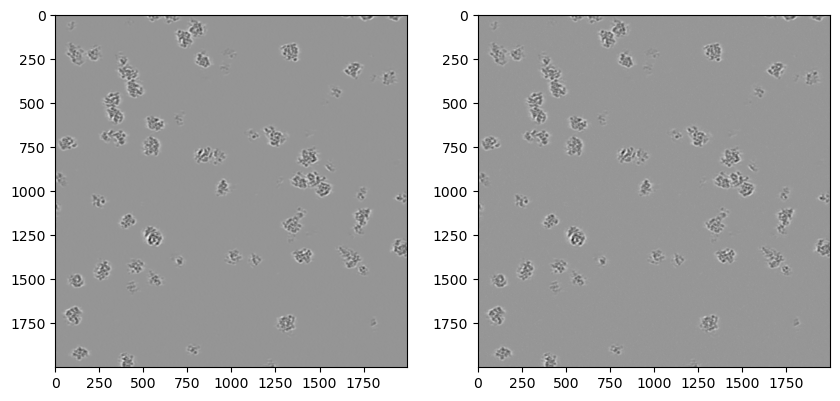

In [1]:
import torch, mrcfile, numpy as np
import matplotlib.pyplot as plt
from torch_fourier_shell_correlation import fsc as external_fsc

denoised_image = mrcfile.read('/Users/HenryJones/Desktop/SULI/cryocare_denoised.mrc')
denoised_tensor = torch.tensor(denoised_image)
mean = torch.zeros_like(denoised_tensor)
std = torch.ones_like(denoised_tensor) * 10

noisy_image = torch.normal(mean = mean, std = std)
del(mean, std, denoised_image)
noisy_image = noisy_image + denoised_tensor

fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].imshow(denoised_tensor[100,:,:].numpy(), cmap = 'Greys_r')
ax[1].imshow(noisy_image[100,:,:].numpy(), cmap = 'Greys_r')

## Full FFT

In [3]:
def make_ffreq_radius(tensor1_shape: torch.Tensor):
    """
    Makes an array marking the Euclidian distance from the center (because we did fftshift) of the fourier domain
    """

    meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0]) - tensor1_shape[0]/2,
                                                    torch.arange(tensor1_shape[1]) - tensor1_shape[1]/2,
                                                    torch.arange(tensor1_shape[2]) - tensor1_shape[2]/2],
                                                    indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2) + torch.pow(meshgrid[2],2))
    del(meshgrid)
    return freq_radius

def _normalised_cc_complex_1d(a: torch.Tensor, b:torch.Tensor):
    correlation = torch.dot(a, torch.conj(b))
    return correlation / (torch.linalg.norm(a) * torch.linalg.norm(b))


def compute_ffsc(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.fftshift(torch.fft.fftn(tensor1), dim = (-3, -2, -1))
    tensor2 = torch.fft.fftshift(torch.fft.fftn(tensor2), dim = (-3, -2, -1))
    assert tensor1.shape == tensor2.shape
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1]/2)**2 + (tensor1.shape[2]/2)**2))
    bin_interval = 10
    bins = torch.arange(0, max_dist + bin_interval, bin_interval) + bin_interval/2
    freq_radius = make_ffreq_radius(tensor1.shape)
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins) #split points are bins
    del(sorted_frequencies_flat, bins)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #if we don't exlude the last one, we just shape of 144?
    del(sort_idx_flat, split_idx)
    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    fsc = torch.real(torch.tensor([
    _normalised_cc_complex_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ]))
    return fsc
    

full_fsc = compute_ffsc(noisy_image, denoised_tensor)

## RFFT
make the datasetup

In [4]:
def make_rfreq_radius(tensor1_shape: torch.Tensor):
    print(tensor1_shape)
    meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0]).float(),
                                torch.arange(tensor1_shape[1]).float(),
                                torch.arange(tensor1_shape[2]).float()], #don't adjust the last one, because we did rfft
                                indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2) + torch.pow(meshgrid[2],2))
    del(meshgrid)
    return freq_radius

def _normalised_cc_real_1d(tensor1: torch.Tensor, tensor2:torch.Tensor):
    correlation = torch.dot(tensor1, torch.conj(tensor2))
    #if tensor1.shape[0] == 0:
    #    return 0
    #else:
    #    correlation = torch.nn.functional.conv1d(tensor1.unsqueeze(0).unsqueeze(0), tensor2.unsqueeze(0).unsqueeze(0))
    return correlation / (torch.linalg.norm(tensor1) * torch.linalg.norm(tensor2))


def compute_rfsc(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.rfftn(tensor1)
    tensor2 = torch.fft.rfftn(tensor2)

    assert tensor1.shape == tensor2.shape
    freq_radius = make_rfreq_radius(tensor1.shape)
    print(freq_radius[99:102, 999:1001, :2])
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    del(freq_radius)

    bin_interval = 10
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1]/2)**2 + (tensor1.shape[2])**2))
    print(max_dist)
    bins = torch.arange(0, max_dist + bin_interval, bin_interval) + bin_interval/2
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins)
    #del(sorted_frequencies_flat)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #exlude last one because of binning
    print(len(shell_index), 'shell shape')
    #del(sort_idx_flat)

    for idx in shell_index[:5]:
        print(idx.shape)

    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    fsc = torch.real(torch.tensor([
    _normalised_cc_real_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ]))   

    return fsc

In [5]:
fsc = compute_rfsc(noisy_image, denoised_tensor)

torch.Size([200, 2000, 1001])
tensor([[[1003.8934, 1003.8939],
         [1004.8885, 1004.8890]],

        [[1003.9926, 1003.9930],
         [1004.9875, 1004.9880]],

        [[1004.0927, 1004.0931],
         [1005.0876, 1005.0881]]])
tensor(1418.4502)
143 shell shape
torch.Size([90])
torch.Size([1932])
torch.Size([6864])
torch.Size([14994])
torch.Size([26210])


In [6]:
external_3d = external_fsc(denoised_tensor, noisy_image)

Text(0.5, 1.0, 'FSC')

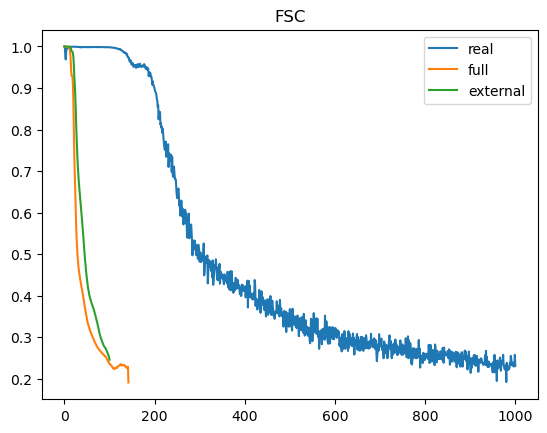

In [35]:
plt.plot(np.arange(len(fsc.numpy())), fsc.numpy(), label= 'real')
plt.plot(np.arange(len(full_fsc.numpy())), np.real(full_fsc.numpy()), label = 'full')
plt.plot(np.arange(len(external_3d.numpy())), external_3d.numpy(), label= 'external')

plt.legend()
plt.title("FSC")


101


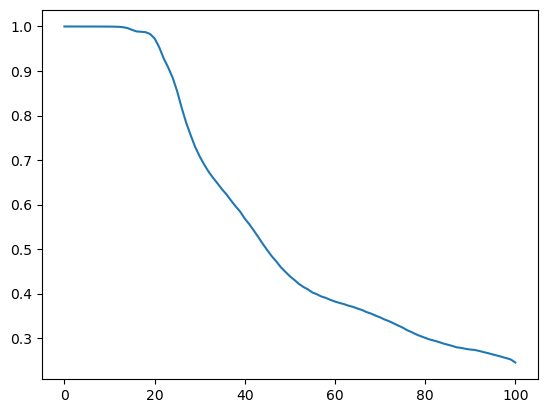

In [8]:
plt.plot(np.arange(len(external_3d)), external_3d.numpy(), label= 'real')
print(len(external_3d))

### 2D Ring testing

In [67]:
def make_ffreq_radius_old(tensor1_shape: torch.Tensor):
    #meshgrid_x, meshgrid_y = torch.meshgrid([torch.fft.fftfreq(tensor1_shape[0]), torch.fft.fftfreq(tensor1_shape[1])])
    meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0]) - tensor1_shape[0]/2,
                            torch.arange(tensor1_shape[1]) - tensor1_shape[1]/2,],
                                                    indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2)) #normalize th
    #del(meshgrid_x, meshgrid_y)
    del(meshgrid)
    return freq_radius

def _normalised_cc_complex_1d(a: torch.Tensor, b:torch.Tensor):
    correlation = torch.dot(a, torch.conj(b))
    return correlation / (torch.linalg.norm(a) * torch.linalg.norm(b))


def compute_ffsc_old(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.fftshift(torch.fft.fft2(tensor1)) #, #dim = (-2, -1))       #These don't seem to do anything 
    tensor2 = torch.fft.fftshift(torch.fft.fft2(tensor2)) #, dim = (-2, -1))        #super noticeable at least in 2d
    print('SHAPES', tensor1.shape, tensor2.shape)

    assert tensor1.shape == tensor2.shape
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1]/2)**2))
    bin_interval = 1
    bins = torch.arange(0, max_dist + bin_interval, bin_interval) + bin_interval/2
    freq_radius = make_ffreq_radius(tensor1.shape)
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins) #split points are bins
    del(sorted_frequencies_flat, bins)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #if we don't exlude the last one, we just shape of 144?
    del(sort_idx_flat, split_idx)
    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    fsc = torch.tensor([
    _normalised_cc_complex_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ])
    return fsc
    
full_fsc_2d_original = compute_ffsc_old(noisy_image[100,:,:], denoised_tensor[100,:,:])

SHAPES torch.Size([2000, 2000]) torch.Size([2000, 2000])


In [68]:
def make_ffreq_radius(tensor1_shape: torch.Tensor):
    meshgrid_x, meshgrid_y = torch.meshgrid([torch.fft.fftfreq(tensor1_shape[0]), torch.fft.fftfreq(tensor1_shape[1])])
    #meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0]) - tensor1_shape[0]/2,
    #                        torch.arange(tensor1_shape[1]) - tensor1_shape[1]/2,],
    #                                                indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid_x,2) + torch.pow(meshgrid_y,2)) #normalize th
    del(meshgrid_x, meshgrid_y)
    return freq_radius

def _normalised_cc_complex_1d(a: torch.Tensor, b:torch.Tensor):
    correlation = torch.dot(a, torch.conj(b))
    return correlation / (torch.linalg.norm(a) * torch.linalg.norm(b))


def compute_ffsc(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.fftshift(torch.fft.fft2(tensor1)) #, #dim = (-2, -1))       #These don't seem to do anything 
    tensor2 = torch.fft.fftshift(torch.fft.fft2(tensor2)) #, dim = (-2, -1))        #super noticeable at least in 2d
    print('SHAPES', tensor1.shape, tensor2.shape)

    assert tensor1.shape == tensor2.shape
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1]/2)**2))
    bin_interval = 1
    bins = torch.arange(0, max_dist + bin_interval, bin_interval) + bin_interval/2
    freq_radius = make_ffreq_radius(tensor1.shape)
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins) #split points are bins
    del(sorted_frequencies_flat, bins)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #if we don't exlude the last one, we just shape of 144?
    del(sort_idx_flat, split_idx)
    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    fsc = torch.tensor([
    _normalised_cc_complex_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ])
    return fsc
    
full_fsc_2d = compute_ffsc(noisy_image[100,:,:], denoised_tensor[100,:,:])

SHAPES torch.Size([2000, 2000]) torch.Size([2000, 2000])


### 2D RFFT

In [2]:
def make_rfreq_radius_old(tensor1_shape: torch.Tensor):
    """The difference here is that I don't shift the first axis for some reason?
    """
    meshgrid = torch.meshgrid([torch.arange(tensor1_shape[0]).float(),
                                torch.arange(tensor1_shape[1]).float()], #don't adjust the last one, because we did rfft
                                indexing = 'ij')
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2))
    del(meshgrid)
    return freq_radius

def _normalised_cc_real_1d(tensor1: torch.Tensor, tensor2:torch.Tensor):
    #correlation = torch.dot(tensor1, torch.conj(tensor2))
    correlation = torch.dot(tensor1, torch.conj(tensor2))
    return correlation / (torch.linalg.norm(tensor1) * torch.linalg.norm(tensor2))


def compute_rfsc_old(tensor1: torch.Tensor, tensor2: torch.Tensor):
    tensor1 = torch.fft.rfft2(tensor1)
    tensor2 = torch.fft.rfft2(tensor2)
    print('SHAPES', tensor1.shape, tensor2.shape)

    assert tensor1.shape == tensor2.shape
    freq_radius = make_rfreq_radius(tensor1.shape)
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    del(freq_radius)

    bin_interval = 1
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1])**2))
    print(max_dist)
    bins = torch.arange(0, max_dist + bin_interval, bin_interval) + bin_interval/2
    split_idx = torch.searchsorted(sorted_frequencies_flat, bins)
    #del(sorted_frequencies_flat)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #exlude last one because of binning
    print(len(shell_index), 'shell shape')
    #del(sort_idx_flat)
    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    for idx in shell_index[70:110]:
        print(tensor1[idx].shape, tensor2[idx].shape)

 
    fsc = torch.tensor([
    _normalised_cc_real_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ])

    return fsc

In [3]:
fsc = external_fsc(denoised_tensor[100,:,:], noisy_image[100,:,:])

## now with frequency grid

In [4]:
print(torch.fft.fftfreq(10), torch.fft.fftshift(torch.fft.fftfreq(10)))
print(torch.fft.rfftfreq(10))

tensor([ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000, -0.5000, -0.4000, -0.3000,
        -0.2000, -0.1000]) tensor([-0.5000, -0.4000, -0.3000, -0.2000, -0.1000,  0.0000,  0.1000,  0.2000,
         0.3000,  0.4000])
tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000])


In [5]:
print(torch.fft.rfftfreq(6))
print(torch.fft.rfftfreq(20))
print(torch.fft.rfftfreq(6, d= 1/np.sqrt(2)))
print(torch.fft.rfftfreq(20, d = 1/np.sqrt(2)))

tensor([0.0000, 0.1667, 0.3333, 0.5000])
tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000,
        0.4500, 0.5000])
tensor([0.0000, 0.2357, 0.4714, 0.7071])
tensor([0.0000, 0.0707, 0.1414, 0.2121, 0.2828, 0.3536, 0.4243, 0.4950, 0.5657,
        0.6364, 0.7071])


In [78]:
def make_rfreq_radius_new(tensor1_shape: torch.Tensor):
    """
    Make our frequency grid using rfftfreq for the last axis
    """
    print('tensor1_shape in make radius', tensor1_shape)
    meshgrid = torch.meshgrid([torch.fft.fftfreq(tensor1_shape[0]),
                                torch.fft.rfftfreq(tensor1_shape[1])],
                                indexing = 'ij')
    print('meshgridshape', meshgrid[0].shape, meshgrid[1].shape)
    freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2))
    print(torch.max(freq_radius), 'max radius', freq_radius.shape)
    del(meshgrid)
    return freq_radius

def _normalised_cc_real_1d(tensor1: torch.Tensor, tensor2:torch.Tensor):
    correlation = torch.dot(tensor1, torch.conj(tensor2))
    return correlation / (torch.linalg.norm(tensor1) * torch.linalg.norm(tensor2))


def compute_rfsc(tensor1: torch.Tensor, tensor2: torch.Tensor):
    print('tensor1shape', tensor1.shape)
    freq_radius = make_rfreq_radius_new(torch.clone(torch.as_tensor(tensor1.shape)))
    max_dist = torch.sqrt(torch.tensor((tensor1.shape[0]/2)**2 + (tensor1.shape[1]/2)**2))
    print('max_dist', max_dist)
    tensor1 = torch.fft.rfft2(tensor1)
    tensor2 = torch.fft.rfft2(tensor2)
    print('SHAPES', tensor1.shape, tensor2.shape)
    assert tensor1.shape == tensor2.shape
    global sorted_frequencies_flat, split_idx
    sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
    print(sorted_frequencies_flat[-10:], 'last10')
    del(freq_radius)
    global bin_centers
    #max_dist = torch.sqrt(torch.tensor((tensor1.shape[0])**2 + (tensor1.shape[1])**2))
    bin_centers = torch.fft.rfftfreq(torch.ceil(max_dist).int(), d = np.cos(np.arctan(1)))
    #spacing allows up to get higher frequencies
    print(bin_centers.shape, torch.max(bin_centers), torch.min(bin_centers), bin_centers[-10:],'original bins')
    bin_interval = 1 / torch.ceil(max_dist) #bin_centers[1] - bin_centers[0]
    print('bin_interbal', bin_interval)
    #skipping is our binning distance
    binning_factor = 2
    bin_centers = torch.cat([bin_centers, torch.as_tensor([bin_centers[-1] + bin_interval])]) #[::binning_factor] 
    print(max_dist)
    bin_centers = bin_centers.unfold(dimension=0, size=2, step=1)
    print(bin_centers.shape)  # (n_shells, 2)
    bin_centers = torch.mean(bin_centers, dim = 1)
    print(bin_centers.shape, bin_centers[:10], 'first/last 10 bins', bin_centers[-10:])  # (n_shells, 1)

    split_idx = torch.searchsorted(sorted_frequencies_flat, bin_centers)
    #del(sorted_frequencies_flat)
    shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #exlude last one because of binning
    print(len(shell_index), 'shell shape')
    #del(sort_idx_flat)
    tensor1 = torch.flatten(tensor1)
    tensor2 = torch.flatten(tensor2)
    for idx in shell_index[-10:]:
        print(tensor1[idx].shape, tensor2[idx].shape, 'last10 shapes')

 
    fsc = torch.tensor([
    _normalised_cc_real_1d(tensor1[idx], tensor2[idx])
    for idx in shell_index
    ])

    return fsc

In [79]:
print(torch.max(torch.fft.fftfreq(2000)), torch.max(torch.fft.rfftfreq(2000)))

tensor(0.4995) tensor(0.5000)


tensor1shape torch.Size([2000, 2000])
tensor1_shape in make radius tensor([2000, 2000])
meshgridshape torch.Size([2000, 1001]) torch.Size([2000, 1001])
tensor(0.7071) max radius torch.Size([2000, 1001])
max_dist tensor(1414.9209)
SHAPES torch.Size([2000, 1001]) torch.Size([2000, 1001])
tensor([0.7060, 0.7064, 0.7064, 0.7064, 0.7064, 0.7064, 0.7068, 0.7068, 0.7068,
        0.7071]) last10
torch.Size([708]) tensor(0.7066) tensor(0.) tensor([0.6976, 0.6986, 0.6996, 0.7006, 0.7016, 0.7026, 0.7036, 0.7046, 0.7056,
        0.7066]) original bins
bin_interbal tensor(0.0007)
tensor(1414.9209)
torch.Size([708, 2])
torch.Size([708]) tensor([0.0005, 0.0015, 0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075, 0.0085,
        0.0095]) first/last 10 bins tensor([0.6981, 0.6991, 0.7001, 0.7011, 0.7021, 0.7031, 0.7041, 0.7051, 0.7061,
        0.7070])
708 shell shape
torch.Size([165]) torch.Size([165]) last10 shapes
torch.Size([147]) torch.Size([147]) last10 shapes
torch.Size([129]) torch.Size([129]) last

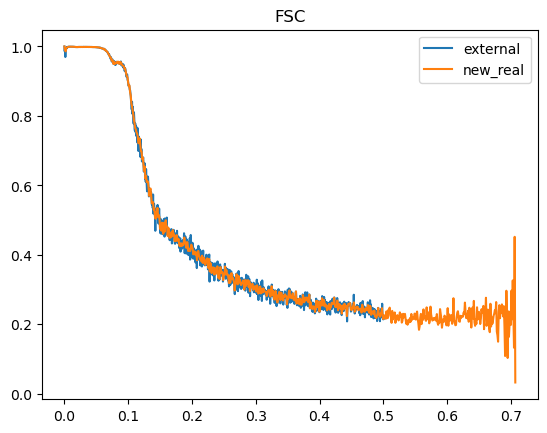

In [81]:
#fsc_r_rd        = compute_rfsc_old(noisy_image[100,:,:], denoised_tensor[100,:,:])
fsc_r_rd_new    = compute_rfsc(noisy_image[100,:,:], denoised_tensor[100,:,:])

print('DIFFERENCES', len(fsc_r_rd_new), len(fsc))
#plt.plot(torch.arange(fsc_r_rd.shape[0]), fsc_r_rd.numpy(), label = 'real')
#plt.plot(torch.arange(fsc_r_rd.shape[0]), np.real(fsc_r_rd.numpy()), label = 'real(real)')
plt.plot(torch.fft.rfftfreq(2000), fsc.numpy(), label = 'external')

plt.plot(torch.fft.rfftfreq(1415, d= np.cos(np.arctan(1))), np.real(fsc_r_rd_new.numpy()), label = 'new_real')
#plt.plot(bin_centers, np.real(fsc_r_rd_new.numpy()), label = 'bin_centers')

#plt.plot(torch.arange(fsc_r_rd.shape[0]), np.imag(fsc_r_rd.numpy()), label = 'imag(real)')

#plt.plot(torch.arange(full_fsc_2d.shape[0]), full_fsc_2d.numpy(), label = 'full')
#plt.plot(torch.arange(full_fsc_2d.shape[0]), np.real(full_fsc_2d.numpy()), label = 'real(full)')
#plt.plot(torch.arange(full_fsc_2d_original.shape[0]), np.real(full_fsc_2d_original.numpy()), label = 'original')

#plt.plot(torch.arange(full_fsc_2d.shape[0]), np.imag(full_fsc_2d.numpy()), label = 'imag(full)')

plt.title("FSC")
plt.legend()

In [68]:
print(bin_centers[:10])
print(torch.fft.rfftfreq(1413, d= np.cos(np.arctan(1))))

tensor([0.0006, 0.0019, 0.0032, 0.0044, 0.0057, 0.0070, 0.0082, 0.0095, 0.0107,
        0.0120])
tensor([0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080,
        0.0090, 0.0100, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0160, 0.0170,
        0.0180, 0.0190, 0.0200, 0.0210, 0.0220, 0.0230, 0.0240, 0.0250, 0.0260,
        0.0270, 0.0280, 0.0290, 0.0300, 0.0310, 0.0320, 0.0330, 0.0340, 0.0350,
        0.0360, 0.0370, 0.0380, 0.0390, 0.0400, 0.0410, 0.0420, 0.0430, 0.0440,
        0.0450, 0.0460, 0.0470, 0.0480, 0.0490, 0.0500, 0.0510, 0.0520, 0.0530,
        0.0540, 0.0550, 0.0560, 0.0570, 0.0580, 0.0591, 0.0601, 0.0611, 0.0621,
        0.0631, 0.0641, 0.0651, 0.0661, 0.0671, 0.0681, 0.0691, 0.0701, 0.0711,
        0.0721, 0.0731, 0.0741, 0.0751, 0.0761, 0.0771, 0.0781, 0.0791, 0.0801,
        0.0811, 0.0821, 0.0831, 0.0841, 0.0851, 0.0861, 0.0871, 0.0881, 0.0891,
        0.0901, 0.0911, 0.0921, 0.0931, 0.0941, 0.0951, 0.0961, 0.0971, 0.0981,
        0.0991, 0.1001,

tensor1shape torch.Size([2000, 2000])
tensor1_shape in make radius tensor([2000, 2000])
meshgridshape torch.Size([2000, 1001]) torch.Size([2000, 1001])
tensor(0.7071) max radius torch.Size([2000, 1001])
max_dist tensor(2236.5154)
SHAPES torch.Size([2000, 1001]) torch.Size([2000, 1001])
tensor([0.7060, 0.7064, 0.7064, 0.7064, 0.7064, 0.7064, 0.7068, 0.7068, 0.7068,
        0.7071]) last10
torch.Size([1119]) tensor(0.7068) tensor(0.) tensor([0.7011, 0.7017, 0.7024, 0.7030, 0.7036, 0.7043, 0.7049, 0.7055, 0.7062,
        0.7068]) original bins
bin_interbal tensor(0.0004)
tensor(2236.5154)
torch.Size([559, 2])
torch.Size([559]) tensor([0.0006, 0.0019, 0.0032, 0.0044, 0.0057, 0.0070, 0.0082, 0.0095, 0.0107,
        0.0120]) first/last 10 bins tensor([0.6948, 0.6960, 0.6973, 0.6986, 0.6998, 0.7011, 0.7024, 0.7036, 0.7049,
        0.7062])
559 shell shape
torch.Size([269]) torch.Size([269]) last10 shapes
torch.Size([228]) torch.Size([228]) last10 shapes
torch.Size([240]) torch.Size([240]) las

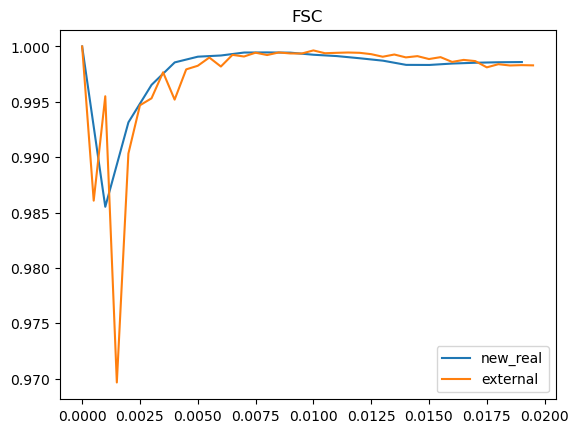

In [69]:
fsc_r_rd_new    = compute_rfsc(noisy_image[100,:,:], denoised_tensor[100,:,:])

print('DIFFERENCES', len(fsc_r_rd_new), len(fsc))
#plt.plot(torch.arange(fsc_r_rd.shape[0]), fsc_r_rd.numpy(), label = 'real')
#plt.plot(torch.arange(fsc_r_rd.shape[0]), np.real(fsc_r_rd.numpy()), label = 'real(real)')
plt.plot(torch.fft.rfftfreq(1413, d= np.cos(np.arctan(1)))[:20], np.real(fsc_r_rd_new.numpy())[:20], label = 'new_real')

#plt.plot(torch.arange(fsc_r_rd.shape[0]), np.imag(fsc_r_rd.numpy()), label = 'imag(real)')

#plt.plot(torch.arange(full_fsc_2d.shape[0]), full_fsc_2d.numpy(), label = 'full')
#plt.plot(torch.arange(full_fsc_2d.shape[0]), np.real(full_fsc_2d.numpy()), label = 'real(full)')
#plt.plot(torch.arange(full_fsc_2d_original.shape[0]), np.real(full_fsc_2d_original.numpy()), label = 'original')

#plt.plot(torch.arange(full_fsc_2d.shape[0]), np.imag(full_fsc_2d.numpy()), label = 'imag(full)')
plt.plot(torch.fft.rfftfreq(2000)[:40], fsc.numpy()[:40], label = 'external')

plt.title("FSC")
plt.legend()

In [70]:
print(torch.fft.rfftfreq(1415, d= np.cos(np.arctan(1)))[-10:])
print(1/np.cos(np.arctan(1)))
print(torch.fft.rfftfreq(1000)[:30])
print(np.cos(np.arctan(1)))

tensor([0.6976, 0.6986, 0.6996, 0.7006, 0.7016, 0.7026, 0.7036, 0.7046, 0.7056,
        0.7066])
1.414213562373095
tensor([0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080,
        0.0090, 0.0100, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0160, 0.0170,
        0.0180, 0.0190, 0.0200, 0.0210, 0.0220, 0.0230, 0.0240, 0.0250, 0.0260,
        0.0270, 0.0280, 0.0290])
0.7071067811865476


In [71]:
print((fsc - torch.real(full_fsc_2d)[:fsc.shape[0]])[:5])

NameError: name 'full_fsc_2d' is not defined

tensor1shape torch.Size([2000, 2000])
tensor1_shape in make radius tensor([2000, 2000])
meshgridshape torch.Size([2000, 1001]) torch.Size([2000, 1001])
tensor(0.7071) max radius torch.Size([2000, 1001])
max_dist tensor(2828.4272)
SHAPES torch.Size([2000, 1001]) torch.Size([2000, 1001])
tensor([0.7060, 0.7064, 0.7064, 0.7064, 0.7064, 0.7064, 0.7068, 0.7068, 0.7068,
        0.7071]) last10
torch.Size([1415]) tensor(0.3534) tensor(0.) tensor([0.3512, 0.3514, 0.3517, 0.3519, 0.3522, 0.3524, 0.3527, 0.3529, 0.3532,
        0.3534]) original bins
bin_interbal tensor(0.0004)
tensor(2828.4272)
torch.Size([1415, 2])
torch.Size([1415]) tensor([0.0001, 0.0004, 0.0006, 0.0009, 0.0011, 0.0014, 0.0016, 0.0019, 0.0021,
        0.0024]) first/last 10 bins tensor([0.3513, 0.3516, 0.3518, 0.3521, 0.3523, 0.3526, 0.3528, 0.3531, 0.3533,
        0.3536])
1415 shell shape
torch.Size([1124]) torch.Size([1124]) last10 shapes
torch.Size([1133]) torch.Size([1133]) last10 shapes
torch.Size([1068]) torch.Size([1

/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


ValueError: x and y must have same first dimension, but have shapes torch.Size([1415]) and (1414,)

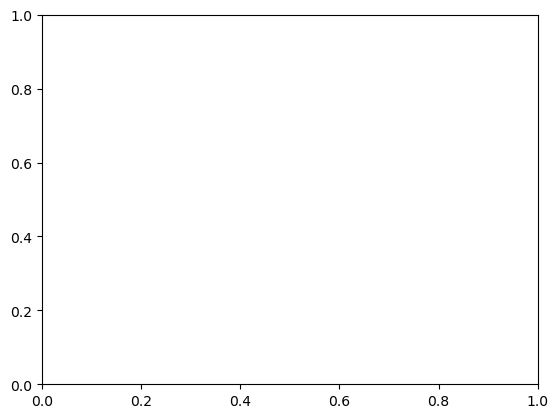

In [415]:
fsc_r_rd = compute_rfsc(noisy_image[100,:,:], denoised_tensor[100,:,:])
max_dist = int(np.ceil(np.sqrt(2000**2 + 2000**2)))
#plt.plot(torch.arange(fsc_r_rd.shape[0]), fsc_r_rd.numpy(), label = 'real')
#plt.plot(torch.arange(full_fsc_2d.shape[0]), full_fsc_2d.numpy(), label = 'real')
#plt.plot(torch.arange(fsc.shape[0]), fsc.numpy(), label = 'external')
x_freq = torch.fft.rfftfreq(2000)
#print(torch.allclose(torch.fft.rfftfreq(max_dist), torch.sqrt(2 * (x_freq**2))))




plt.plot(torch.fft.rfftfreq(max_dist), fsc_r_rd.numpy()[:-1], label = 'real')
max_dist_r = int(np.ceil(np.sqrt(1000**2 + 1001**2)))

#plt.plot(torch.fft.fftfreq(max_dist_r), fsc_r_rd.numpy()[:-1], label = 'real')
#plt.plot(torch.arange(full_fsc_2d.shape[0]), full_fsc_2d.numpy(), label = 'real')
#plt.plot(torch.arange(fsc.shape[0]), fsc.numpy(), label = 'external')
plt.legend()

## 1d trials

In [77]:
x = np.linspace(0, 4 * (np.pi **2), num = 100)
print(np.shape(x))
empty = np.zeros_like(x)
for i in range(1,10):
    empty+= (1/i)*(np.cos((x*i)/(2*np.pi))) + (1/(i**2))*(np.sin((x*i)/(2*np.pi)))
values = empty
print(values[:5])

(100,)
[2.82896825 2.91734105 2.8319577  2.60740486 2.29943867]


In [78]:
time_domain = torch.tensor(values)

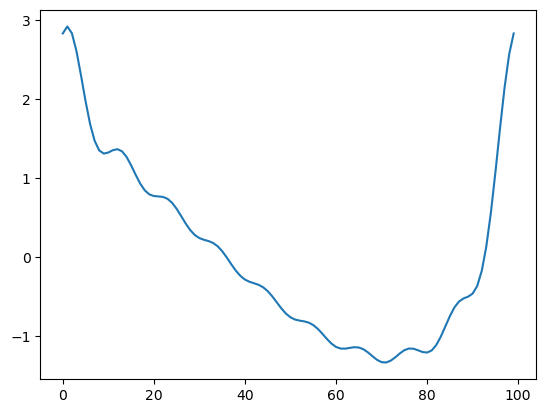

In [79]:
plt.plot(np.arange(len(values)), values)

## Just the data

/Users/HenryJones/miniconda3/envs/envupdate/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


<StemContainer object of 3 artists>

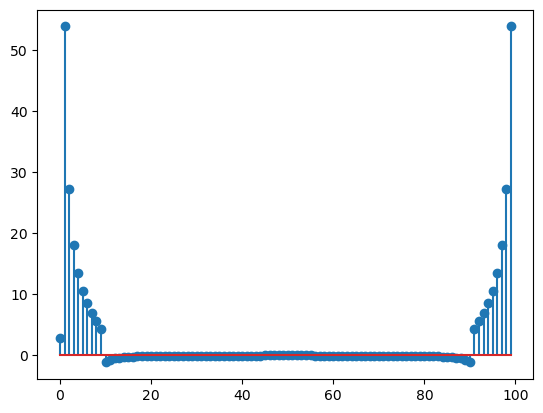

In [80]:
plt.stem(np.arange(len(values)), torch.fft.fft(time_domain).numpy())

In [81]:
def _normalised_cc_complex_1d(tensor1: torch.Tensor, tensor2:torch.Tensor):
    #correlation = torch.dot(tensor1, torch.conj(tensor2))
    correlation = torch.dot(tensor1, torch.conj(tensor2))
    return correlation / (torch.linalg.norm(tensor1) * torch.linalg.norm(tensor2))

# FULL 1d FSC

In [82]:
noisy_values = time_domain + torch.normal(torch.zeros_like(time_domain), torch.ones_like(time_domain) * 0.01)

In [83]:
fsc_1df = []
print(time_domain.shape)
distance = torch.arange(0, time_domain.shape[0])
grid = distance - (time_domain.shape[0]-1)/2
distances, idx = torch.sort(grid, descending = False)
split_idx = torch.searchsorted(distances, torch.arange(51))
shell_index = torch.tensor_split(idx, split_idx)[:-1]

for id in shell_index:
    fsc_1df.append(_normalised_cc_complex_1d(torch.fft.fftshift(torch.fft.fft(time_domain))[id], 
                                             torch.fft.fftshift(torch.fft.fft(noisy_values))[id]))
    
print(fsc_1df[-1])

torch.Size([100])
tensor(0.2215-0.9752j, dtype=torch.complex128)


## Now trying to do real

torch.Size([100])
torch.Size([52])
52
tensor([], dtype=torch.complex128) tensor([], dtype=torch.complex128)
tensor([2.8290+0.j], dtype=torch.complex128) tensor([2.9594+0.j], dtype=torch.complex128)
tensor([53.8541-48.3126j], dtype=torch.complex128) tensor([53.8472-48.3172j], dtype=torch.complex128)
tensor([27.2157-10.2741j], dtype=torch.complex128) tensor([27.2769-10.2713j], dtype=torch.complex128)
tensor([18.1052-3.3207j], dtype=torch.complex128) tensor([18.0992-3.4157j], dtype=torch.complex128)
tensor([13.4087-0.9401j], dtype=torch.complex128) tensor([13.3371-1.0137j], dtype=torch.complex128)
tensor([10.4833+0.1198j], dtype=torch.complex128) tensor([10.3953+0.1198j], dtype=torch.complex128)
tensor([8.4368+0.6558j], dtype=torch.complex128) tensor([8.4503+0.7723j], dtype=torch.complex128)
tensor([6.8733+0.9361j], dtype=torch.complex128) tensor([7.0177+1.0344j], dtype=torch.complex128)
tensor([5.5656+1.0645j], dtype=torch.complex128) tensor([5.6503+0.9589j], dtype=torch.complex128)
tens

/var/folders/gr/_q7_46ws0hl7qy90fpjmx3tw0000gq/T/ipykernel_32997/3570369786.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corellation = torch.tensor(_normalised_cc_complex_1d(torch.fft.rfft(time_domain)[id],


Text(0.5, 1.0, 'FSC')

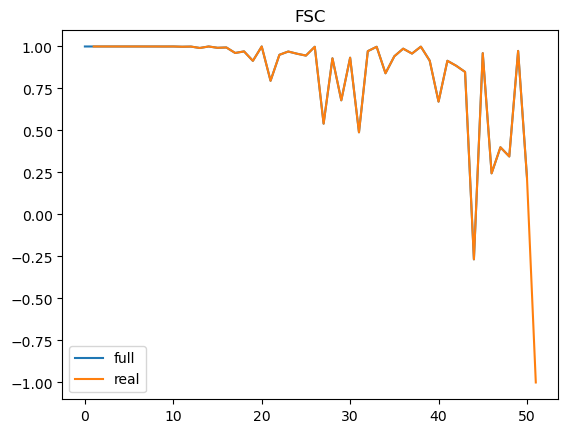

In [84]:
fsc_1dr = []
print(time_domain.shape)
distance = torch.arange(0, torch.fft.rfft(time_domain).shape[0]+1)
print(distance.shape)
#grid = distance - (time_domain.shape[0]-1)/2
grid = distance
distances, idx = torch.sort(grid, descending = False)
split_idx = torch.searchsorted(distances, torch.arange(52))
shell_index = torch.tensor_split(idx, split_idx)[:-1]
print(len(shell_index))
for id in shell_index:
    print(torch.fft.rfft(time_domain)[id], torch.fft.rfft(noisy_values)[id])
    corellation = torch.tensor(_normalised_cc_complex_1d(torch.fft.rfft(time_domain)[id], 
                                                        torch.fft.rfft(noisy_values)[id]))
    fsc_1dr.append(torch.real(corellation))

print(len(fsc_1df), 'full')
print(len(fsc_1dr), 'real')
print(fsc_1df[0], fsc_1df[-1], fsc_1dr[0], fsc_1dr[-1], 'HERE')

plt.plot(np.arange(51), fsc_1df, label = 'full')
plt.plot(np.arange(52), fsc_1dr, label = 'real')
plt.legend()
plt.title("FSC")

In [85]:
print(fsc_1dr[0])

tensor(nan, dtype=torch.float64)


## plot the parts that are the same

Text(0.5, 1.0, 'FSC')

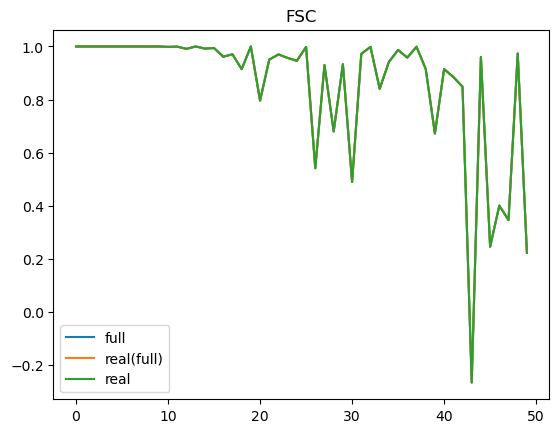

In [86]:
plt.plot(np.arange(50), fsc_1df[1:], label = 'full')
plt.plot(np.arange(50), np.real(fsc_1df[1:]), label = 'real(full)')

plt.plot(np.arange(50), fsc_1dr[1:-1], label = 'real')
#plt.plot(np.arange(50), np.imag(fsc_1df[1:]), label = 'imag of full')
#plt.plot(np.arange(50), np.abs(fsc_1df[1:]), label = 'abs of full')


plt.legend()
plt.title("FSC")

In [87]:
print(fsc_1df)
print(fsc_1dr[1:-1])
print(np.max(np.array(fsc_1dr[1:-1]) - np.array(fsc_1df[1:])))
print(np.min(np.array(fsc_1dr[1:-1]) - np.array(fsc_1df[1:])))
print(np.real(np.array(fsc_1dr[1:-1])) == np.real(np.array(fsc_1df[1:])))

[tensor(1.0000-0.0003j, dtype=torch.complex128), tensor(1.+0.j, dtype=torch.complex128), tensor(1.0000+0.0001j, dtype=torch.complex128), tensor(1.0000-0.0008j, dtype=torch.complex128), tensor(1.0000+0.0051j, dtype=torch.complex128), tensor(1.0000+0.0059j, dtype=torch.complex128), tensor(1.0000-0.0001j, dtype=torch.complex128), tensor(0.9999-0.0136j, dtype=torch.complex128), tensor(0.9999-0.0110j, dtype=torch.complex128), tensor(0.9998+0.0209j, dtype=torch.complex128), tensor(1.0000+0.0007j, dtype=torch.complex128), tensor(0.9985+0.0551j, dtype=torch.complex128), tensor(0.9994+0.0348j, dtype=torch.complex128), tensor(0.9911-0.1335j, dtype=torch.complex128), tensor(1.0000-0.0064j, dtype=torch.complex128), tensor(0.9921-0.1254j, dtype=torch.complex128), tensor(0.9941+0.1086j, dtype=torch.complex128), tensor(0.9613-0.2754j, dtype=torch.complex128), tensor(0.9707-0.2404j, dtype=torch.complex128), tensor(0.9145+0.4045j, dtype=torch.complex128), tensor(0.9999+0.0102j, dtype=torch.complex128),

## WIth fftfreq

<StemContainer object of 3 artists>

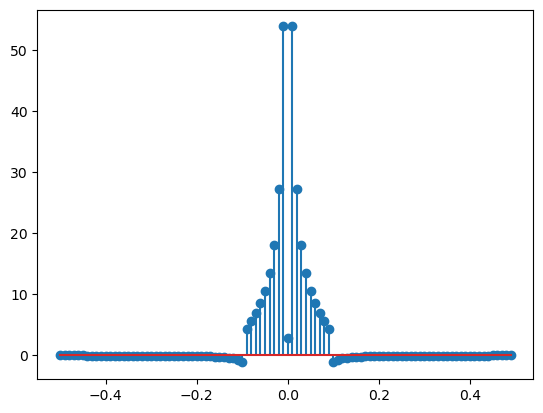

In [88]:
plt.stem(torch.fft.fftfreq(time_domain.shape[0]).numpy(), torch.fft.fft(time_domain).numpy())

## fftshift instead of fftfreq

ValueError: could not broadcast input array from shape (100,) into shape (101,)

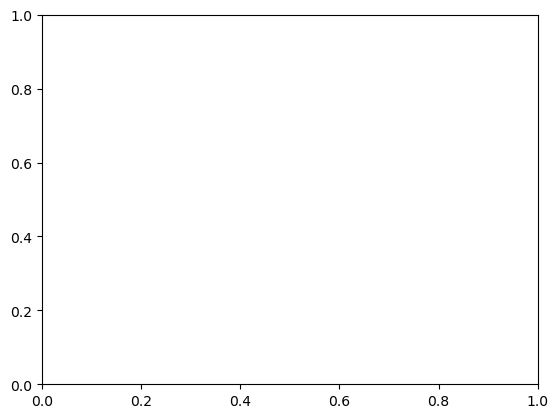

In [89]:
plt.stem(np.linspace(-(4*(np.pi **2)/101), 4*(np.pi **2)/101, 101),torch.fft.fftshift(torch.fft.fft(time_domain)).numpy())

<StemContainer object of 3 artists>

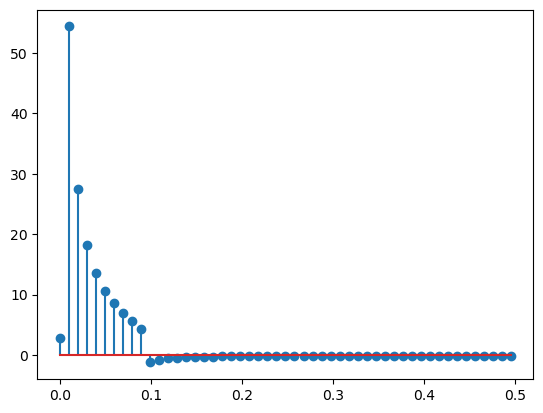

In [67]:
plt.stem(torch.fft.rfftfreq(time_domain.shape[0]).numpy(), torch.fft.rfft(time_domain).numpy())

<StemContainer object of 3 artists>

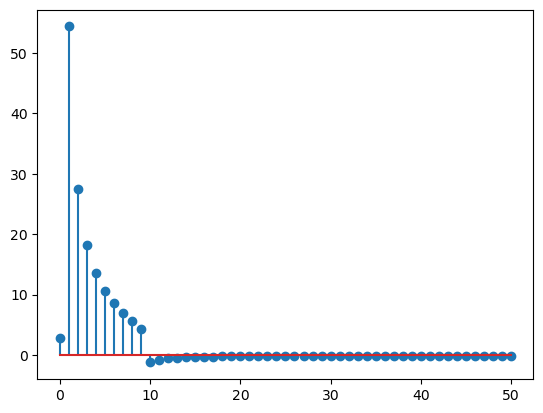

In [68]:
plt.stem(np.arange(time_domain.shape[0]/2), torch.fft.rfft(time_domain).numpy())

In [69]:
print(torch.fft.fftfreq(len(time_domain)))

tensor([ 0.0000,  0.0099,  0.0198,  0.0297,  0.0396,  0.0495,  0.0594,  0.0693,
         0.0792,  0.0891,  0.0990,  0.1089,  0.1188,  0.1287,  0.1386,  0.1485,
         0.1584,  0.1683,  0.1782,  0.1881,  0.1980,  0.2079,  0.2178,  0.2277,
         0.2376,  0.2475,  0.2574,  0.2673,  0.2772,  0.2871,  0.2970,  0.3069,
         0.3168,  0.3267,  0.3366,  0.3465,  0.3564,  0.3663,  0.3762,  0.3861,
         0.3960,  0.4059,  0.4158,  0.4257,  0.4356,  0.4455,  0.4554,  0.4653,
         0.4752,  0.4851,  0.4950, -0.4950, -0.4851, -0.4752, -0.4653, -0.4554,
        -0.4455, -0.4356, -0.4257, -0.4158, -0.4059, -0.3960, -0.3861, -0.3762,
        -0.3663, -0.3564, -0.3465, -0.3366, -0.3267, -0.3168, -0.3069, -0.2970,
        -0.2871, -0.2772, -0.2673, -0.2574, -0.2475, -0.2376, -0.2277, -0.2178,
        -0.2079, -0.1980, -0.1881, -0.1782, -0.1683, -0.1584, -0.1485, -0.1386,
        -0.1287, -0.1188, -0.1089, -0.0990, -0.0891, -0.0792, -0.0693, -0.0594,
        -0.0495, -0.0396, -0.0297, -0.01

In [70]:
print(torch.fft.rfftfreq(len(time_domain)))

tensor([0.0000, 0.0099, 0.0198, 0.0297, 0.0396, 0.0495, 0.0594, 0.0693, 0.0792,
        0.0891, 0.0990, 0.1089, 0.1188, 0.1287, 0.1386, 0.1485, 0.1584, 0.1683,
        0.1782, 0.1881, 0.1980, 0.2079, 0.2178, 0.2277, 0.2376, 0.2475, 0.2574,
        0.2673, 0.2772, 0.2871, 0.2970, 0.3069, 0.3168, 0.3267, 0.3366, 0.3465,
        0.3564, 0.3663, 0.3762, 0.3861, 0.3960, 0.4059, 0.4158, 0.4257, 0.4356,
        0.4455, 0.4554, 0.4653, 0.4752, 0.4851, 0.4950])
